## Курсовая «Титаник» 

https://www.kaggle.com/c/titanic

### Predict survival on the Titanic
Предсказать вероятность спасения пассажира при катастрофе

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Исследование данных 

In [99]:
train = pd.read_csv('titanic/train.csv')

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Общий вид данных

In [101]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [152]:
y_full_train = train['Survived']

Посмотрим на данные в разрезе их типов

In [102]:
display(train.describe(include=['object']))
display(train.describe(include=['int64']))
display(train.describe(include=['float64']))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


,PassengerId,Survived,Pclass,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.523008,0.381594
std,257.353842,0.486592,0.836071,1.102743,0.806057
min,1.000000,0.000000,1.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,8.000000,6.000000


,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


Видим, что данные имеют пропуски. Присутствуют и категориальные и вещественные признаки.

Исследуем тестовый набор

In [103]:
test = pd.read_csv('titanic/test.csv')

In [104]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [105]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


тестовая и обучающая выборка отличаются тем, что в обучающей выборке присутствует целевой вектор

Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [106]:
categorical_cols_train = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
numeric_cols_train = list(set(train.columns.values.tolist()) - set(categorical_cols_train))

categorical_cols_test = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
numeric_cols_test = list(set(test.columns.values.tolist()) - set(categorical_cols_test))

можно отдельно посмотреть количество NaN элементов в подвыборке в разрезе признаков

In [107]:
print train[numeric_cols_train].isnull().sum(), '\n'
print train[categorical_cols_train].isnull().sum(), '\n'
print test[numeric_cols_test].isnull().sum(), '\n'
print test[categorical_cols_test].isnull().sum()

Fare             0
Age            177
Parch            0
Pclass           0
Survived         0
SibSp            0
PassengerId      0
dtype: int64 

Name          0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64 

Fare            1
Age            86
Parch           0
Pclass          0
SibSp           0
PassengerId     0
dtype: int64 

Name          0
Sex           0
Ticket        0
Cabin       327
Embarked      0
dtype: int64


пропущенные значения присутствуют как в тестовой, так и в обучающей выборках, как в числовых, так и в категориальных признаках. данные необходимо дополнить а затем нормализовывать.

нужно также исследовать сбалансированность обучающей выборки

In [108]:
not_surv = np.sum(train['Survived']==0)
surv = np.sum(train['Survived']==1)
print float(surv)/not_surv

0.622950819672


обучающая выборка не сбалансированная, с преобладанием данных о погибших 

### Итак. Общий вывод по результатам исследования состояния данных: 
#### 1. В наборе присутствуют и категориальные и вещественные признаки. Следовательно, категориальные нужно преобразовать для последующей обработки.
#### 2. В данных имеются значительные пропуски, которые могут повлиять на обучение. Требуется заполнить пропущенные значения.
#### 3. Кроме того, данные обучающей выборки не сбалансированы. Возможно, необходимо сбалансировать. 

преобразуем пропуски в категориальных признаках в NA

In [109]:
X_cat_train = train[categorical_cols_train].fillna('NA').astype(str)
X_cat_test = test[categorical_cols_test].fillna('NA').astype(str)
display(X_cat_train.head(3))
display(X_cat_test.head(3))

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NA,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NA,S


,Name,Sex,Ticket,Cabin,Embarked
0,"Kelly, Mr. James",male,330911,NA,Q
1,"Wilkes, Mrs. James (Ellen Needs)",female,363272,NA,S
2,"Myles, Mr. Thomas Francis",male,240276,NA,Q


признак пола бинарный, его можно заменить на 1 и 0

In [110]:
X_cat_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [111]:
for dataset in [X_cat_train, X_cat_test]:
    dataset['Sex'] = dataset['Sex'].map({"male": 1, "female": 2}).fillna(0)
    
display(X_cat_train.head(3))
display(X_cat_test.head(3))

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",1,A/5 21171,NA,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",2,STON/O2. 3101282,NA,S


,Name,Sex,Ticket,Cabin,Embarked
0,"Kelly, Mr. James",1,330911,NA,Q
1,"Wilkes, Mrs. James (Ellen Needs)",2,363272,NA,S
2,"Myles, Mr. Thomas Francis",1,240276,NA,Q


признак Embarked имеет больше чем 2 значения и пропуски

In [112]:
X_cat_train['Embarked'].value_counts()

S     644
C     168
Q      77
NA      2
Name: Embarked, dtype: int64

неизвестные данные в виду малости присоединим к наиболее частому, и присвоим данным значения в границах от 0 до 1

In [113]:
for dataset in [X_cat_train, X_cat_test]:
    dataset['Embarked'] = dataset['Embarked'].map({"S": 0.1, "C": 0.2, "Q": 0.3, "NA": 0.1}).fillna(0)
    
display(X_cat_train.head(3))
display(X_cat_test.head(3))

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",1,A/5 21171,NA,0.1
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,PC 17599,C85,0.2
2,"Heikkinen, Miss. Laina",2,STON/O2. 3101282,NA,0.1


,Name,Sex,Ticket,Cabin,Embarked
0,"Kelly, Mr. James",1,330911,NA,0.3
1,"Wilkes, Mrs. James (Ellen Needs)",2,363272,NA,0.1
2,"Myles, Mr. Thomas Francis",1,240276,NA,0.3


исследуем влияние места посадки на борт на выживаемость

In [114]:
X_train_touch_1 = pd.DataFrame([X_cat_train['Embarked'], train['Survived']]).T
display(X_train_touch_1.head(3))
X_train_touch_1[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,0.1,0.0
1,0.2,1.0
2,0.1,1.0


,Embarked,Survived
1,0.2,0.553571
2,0.3,0.389610
0,0.1,0.339009


наблюдаем незначительное превышение выживаемости в группе 0.2.
исследуем влияние гендерного признака на выживаемость

In [115]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


и очевидно что признак пола существенно влияет на выживание 

In [116]:
X_cat_train['Embarked'].value_counts()

0.1    646
0.2    168
0.3     77
Name: Embarked, dtype: int64

в признак Cabin неопределенные данные занимают 77% от выборки, этот признак исключаем 

возможно признаком, влияющим на выживаемость является тип билета. нужно его исследовать. Для этого делим билеты по группам исходя из количества знаков в номере билета

In [117]:
display(X_cat_train['Ticket'].values[:10])
aa = []
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
for i in range(len(X_cat_train['Ticket'].values)):
    if len(X_cat_train['Ticket'].values[i]) < 5:
        count_4 += 1
    if len(X_cat_train['Ticket'].values[i]) == 5:
        count_5 += 1
    if len(X_cat_train['Ticket'].values[i]) == 6:
        count_6 += 1
    if len(X_cat_train['Ticket'].values[i]) == 7:
        count_7 += 1
    if len(X_cat_train['Ticket'].values[i]) > 7:
        count_8 += 1
    aa.append(len(X_cat_train['Ticket'].values[i]))
print len(aa)
print count_4, count_5, count_6, count_7, count_8, 
print count_4+count_5+count_6+count_7+count_8

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736'], dtype=object)

891
103 131 419 27 211 891


In [118]:
X_cat_train['Ticket_level'] = 0
for i in range(len(X_cat_train['Ticket'].values)):
    if len(X_cat_train['Ticket'].values[i]) < 5:
        X_cat_train['Ticket_level'][i] = 1
    if len(X_cat_train['Ticket'].values[i]) == 5:
        X_cat_train['Ticket_level'][i] = 2
    if len(X_cat_train['Ticket'].values[i]) == 6:
        X_cat_train['Ticket_level'][i] = 3
    if len(X_cat_train['Ticket'].values[i]) == 7:
        X_cat_train['Ticket_level'][i] = 4
    if len(X_cat_train['Ticket'].values[i]) > 7:
        X_cat_train['Ticket_level'][i] = 5

X_cat_test['Ticket_level'] = 0
for i in range(len(X_cat_test['Ticket'].values)):
    if len(X_cat_test['Ticket'].values[i]) < 5:
        X_cat_test['Ticket_level'][i] = 1
    if len(X_cat_test['Ticket'].values[i]) == 5:
        X_cat_test['Ticket_level'][i] = 2
    if len(X_cat_test['Ticket'].values[i]) == 6:
        X_cat_test['Ticket_level'][i] = 3
    if len(X_cat_test['Ticket'].values[i]) == 7:
        X_cat_test['Ticket_level'][i] = 4
    if len(X_cat_test['Ticket'].values[i]) > 7:
        X_cat_test['Ticket_level'][i] = 5


/home/thomas/anaconda2/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/thomas/anaconda2/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/thomas/anaconda2/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/thomas/anaconda2/envs/env_py2/lib/python2.7/site-packa

In [119]:
X_cat_train.drop(columns=['Ticket'], inplace=True)
X_cat_test.drop(columns=['Ticket'], inplace=True)

In [120]:
display(X_cat_train.head(3))
display(X_cat_test.head(3))

,Name,Sex,Cabin,Embarked,Ticket_level
0,"Braund, Mr. Owen Harris",1,NA,0.1,5
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,C85,0.2,5
2,"Heikkinen, Miss. Laina",2,NA,0.1,5


,Name,Sex,Cabin,Embarked,Ticket_level
0,"Kelly, Mr. James",1,NA,0.3,3
1,"Wilkes, Mrs. James (Ellen Needs)",2,NA,0.1,3
2,"Myles, Mr. Thomas Francis",1,NA,0.3,3


In [121]:
X_train_touch_1 = pd.DataFrame([X_cat_train['Ticket_level'], train['Survived']]).T
display(X_train_touch_1.head(3))
X_train_touch_1[['Ticket_level', 'Survived']].groupby(['Ticket_level'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Ticket_level,Survived
0,5,0
1,5,1
2,5,1


,Ticket_level,Survived
1,2,0.618321
4,5,0.388626
0,1,0.359223
2,3,0.319809
3,4,0.296296


выживаемость в группах близка друг другу. но на их фоне выделяется группа Ticket_level 2. 

остались не рассмотрены имена пассажиров.

In [122]:
X_cat_train['Name'].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

наблюдаем в структуре обращение, по которому можно классифицировать - типа Miss

In [123]:
X_cat_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

создаем колонку с новым признаком

In [124]:
X_cat_train['title'] = X_cat_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_cat_test['title'] = X_cat_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [125]:
X_cat_train['title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: title, dtype: int64

укрупняем группы путем объединения синонимичных и слияния редких

In [126]:
for dataset in [X_cat_train, X_cat_test]:
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

очевидно что группы укрупнены существенно. смотрим влияние принадлежности к группе на выживаемость 

In [127]:
X_train_touch_3 = pd.merge(X_cat_train['title'], train['Survived'], left_index=True, right_index=True ) 
X_train_touch_3[['title', 'Survived']].groupby(['title'], as_index=False).mean().sort_values(by='title', ascending=False)

,title,Survived
4,Rare,0.347826
3,Mrs,0.793651
2,Mr,0.156673
1,Miss,0.702703
0,Master,0.575000


наблюдаем неравномерное распределение выживаемости среди групп, что свидетельствует о возможном влиянии принадлежности к группе на выживаемость. теперь можно удалить признак имя, поскольку мы его уже испльзовали

In [128]:
for dataset in [X_cat_train, X_cat_test]:
    dataset.drop(columns=['Name'], inplace=True)
X_cat_train.head(3)

,Sex,Cabin,Embarked,Ticket_level,title
0,1,NA,0.1,5,Mr
1,2,C85,0.2,5,Mrs
2,2,NA,0.1,5,Miss


теперь закодируем новый признак

In [129]:
for dataset in [X_cat_train, X_cat_test]:
    dataset['title'] = dataset['title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}).fillna(0)
    
display(X_cat_train.head(3))
display(X_cat_test.head(3))

,Sex,Cabin,Embarked,Ticket_level,title
0,1,NA,0.1,5,1
1,2,C85,0.2,5,3
2,2,NA,0.1,5,2


,Sex,Cabin,Embarked,Ticket_level,title
0,1,NA,0.3,3,1
1,2,NA,0.1,3,3
2,1,NA,0.3,3,1


#### считаем категориальные признаки готовыми к обработке в алгоритме 

#### начинаем работу с вещественными признаками

в признаке Age есть пропуски. поскольку это возраст, целесообразно заменить пропуски на среднее значение 

In [130]:
X_num_train = train[numeric_cols_train].fillna(np.median(train['Age'].median())).astype(float)
X_num_test = test[numeric_cols_test].fillna(np.median(test['Age'].median())).astype(float)
display(X_num_train.head(3))
display(X_num_test.head(3))

,Fare,Age,Parch,Pclass,Survived,SibSp,PassengerId
0,7.2500,22.0,0.0,3.0,0.0,1.0,1.0
1,71.2833,38.0,0.0,1.0,1.0,1.0,2.0
2,7.9250,26.0,0.0,3.0,1.0,0.0,3.0


,Fare,Age,Parch,Pclass,SibSp,PassengerId
0,7.8292,34.5,0.0,3.0,0.0,892.0
1,7.0000,47.0,0.0,3.0,1.0,893.0
2,9.6875,62.0,0.0,2.0,0.0,894.0


признак PassengerId имеет порядковый характер. явно неинформативен для обработки. удаляем его

In [131]:
for dataset in [X_num_train, X_num_test]:
    dataset.drop(columns=['PassengerId'], inplace=True)
display(X_num_train.head(3))
display(X_num_test.head(3))

,Fare,Age,Parch,Pclass,Survived,SibSp
0,7.2500,22.0,0.0,3.0,0.0,1.0
1,71.2833,38.0,0.0,1.0,1.0,1.0
2,7.9250,26.0,0.0,3.0,1.0,0.0


,Fare,Age,Parch,Pclass,SibSp
0,7.8292,34.5,0.0,3.0,0.0
1,7.0000,47.0,0.0,3.0,1.0
2,9.6875,62.0,0.0,2.0,0.0


создаем признак Размер семьи и отдельно признак Одиночка

In [132]:
for dataset in [X_num_train, X_num_test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in [X_num_train, X_num_test]:
    dataset['Alone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'Alone'] = 1
display(X_num_train.head(3))
display(X_num_test.head(3))

,Fare,Age,Parch,Pclass,Survived,SibSp,FamilySize,Alone
0,7.2500,22.0,0.0,3.0,0.0,1.0,2.0,0
1,71.2833,38.0,0.0,1.0,1.0,1.0,2.0,0
2,7.9250,26.0,0.0,3.0,1.0,0.0,1.0,1


,Fare,Age,Parch,Pclass,SibSp,FamilySize,Alone
0,7.8292,34.5,0.0,3.0,0.0,1.0,1
1,7.0000,47.0,0.0,3.0,1.0,2.0,0
2,9.6875,62.0,0.0,2.0,0.0,1.0,1


удаляем лишние колонки

In [133]:
X_num_train = X_num_train.drop(['Parch', 'SibSp'], axis=1)
X_num_test = X_num_test.drop(['Parch', 'SibSp'], axis=1)
display(X_num_train.head(3))
display(X_num_test.head(3))

,Fare,Age,Pclass,Survived,FamilySize,Alone
0,7.2500,22.0,3.0,0.0,2.0,0
1,71.2833,38.0,1.0,1.0,2.0,0
2,7.9250,26.0,3.0,1.0,1.0,1


,Fare,Age,Pclass,FamilySize,Alone
0,7.8292,34.5,3.0,1.0,1
1,7.0000,47.0,3.0,2.0,0
2,9.6875,62.0,2.0,1.0,1


In [134]:
X_num_train = X_num_train.drop(['FamilySize'], axis=1)
X_num_test = X_num_test.drop(['FamilySize'], axis=1)
display(X_num_train.head(3))
display(X_num_test.head(3))

,Fare,Age,Pclass,Survived,Alone
0,7.2500,22.0,3.0,0.0,0
1,71.2833,38.0,1.0,1.0,0
2,7.9250,26.0,3.0,1.0,1


,Fare,Age,Pclass,Alone
0,7.8292,34.5,3.0,1
1,7.0000,47.0,3.0,0
2,9.6875,62.0,2.0,1


In [151]:
X_num_train_new = X_num_train[['Fare', 'Age', 'Pclass', 'Alone']]
y_full_train = train['Survived']
display(X_num_train_new.head(3))
display(X_num_train_new.shape)
display(y_train.head(3))

,Fare,Age,Pclass,Alone
0,7.2500,22.0,3.0,0
1,71.2833,38.0,1.0,0
2,7.9250,26.0,3.0,1


(891, 4)

140    0
439    0
817    0
Name: Survived, dtype: int64

#### обработку вещественных признаков считаем законченной 

собираем вместе наборы признаков - категориальные и вещественные в одну выборку

In [136]:
X_full_train = pd.merge(X_cat_train, X_num_train_new, left_index=True, right_index=True ) 
X_full_test = pd.merge(X_cat_test, X_num_test, left_index=True, right_index=True ) 
display(X_full_train.head(3))
display(X_full_test.head(3))

,Sex,Cabin,Embarked,Ticket_level,title,Fare,Age,Pclass,Alone
0,1,NA,0.1,5,1,7.2500,22.0,3.0,0
1,2,C85,0.2,5,3,71.2833,38.0,1.0,0
2,2,NA,0.1,5,2,7.9250,26.0,3.0,1


,Sex,Cabin,Embarked,Ticket_level,title,Fare,Age,Pclass,Alone
0,1,NA,0.3,3,1,7.8292,34.5,3.0,1
1,2,NA,0.1,3,3,7.0000,47.0,3.0,0
2,1,NA,0.3,3,1,9.6875,62.0,2.0,1


In [137]:
for dataset in [X_full_train, X_full_test]:
    dataset.drop(columns=['Cabin'], inplace=True)

X_full_train.head(3)

,Sex,Embarked,Ticket_level,title,Fare,Age,Pclass,Alone
0,1,0.1,5,1,7.2500,22.0,3.0,0
1,2,0.2,5,3,71.2833,38.0,1.0,0
2,2,0.1,5,2,7.9250,26.0,3.0,1


In [138]:
display(X_full_train.shape)
display(y_train.shape)

(891, 8)

(891,)

#### разделяем данные на обучающую и тестовую выборку 

In [139]:
from sklearn.model_selection import train_test_split

In [153]:
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, 
                                                  test_size=0.20, random_state=0)

In [154]:
print X_train.shape
print X_val.shape

(712, 8)
(179, 8)


#### Логистическая регрессия
В методе логистической регрессии значением функции является вероятность того, что данное исходное значение принадлежит к определенному классу. В нашем случае - "спасен/нет"

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

пробуем предсказать целевой вектор на самостоятельно разделенной выборке, используя базовые настройки

In [320]:
logreg_val = LogisticRegression()
logreg_val.fit(X_train, y_train)
pred_val = logreg_val.predict(X_val)
display(accuracy_score(y_val, pred_val))

0.776536312849162

#### используем кросс-валидацию 
кросс-валидация это метод оценки аналитической модели и её поведения на независимых данных. При оценке модели имеющиеся в наличии данные разбиваются на k частей. Затем на k−1 частях данных производится обучение модели, а оставшаяся часть данных используется для тестирования. Процедура повторяется k раз; в итоге каждая из k частей данных используется для тестирования. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных.

In [321]:
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_full_train, y_full_train, cv=5)
display(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([0.80446927, 0.80446927, 0.78651685, 0.79213483, 0.81355932])

Accuracy: 0.80 (+/- 0.02)


#### подбираем параметры логистической регрессии

In [198]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

можно обучить логистическую регрессию, подбирая параметры из заданной сетки param_grid 
по методу кросс-валидации с заланным числом фолдов cv= . 
В качестве оптимизируемой функции мы используем заданную по умолчанию.

Попробуем работать на разделенной однократно выборке

In [354]:
# задаем параметры сетки через словарь параметров. параметры сетки - параметры для перебора:
xx = np.arange(1, 30, 1)
param_grid = {'C': xx}
# задаем число разделений обучающей подвыборки:
cv = 5
# задаем обучающий алгоритм - объект класса LogisticRegression()
# указываем penalty - 'l1' или 'l2' (по умолчанию 'l2')
# L2-регуляризация предотвращает переобучения модели путём запрета 
# на непропорционально большие весовые коэффициенты.
# L1-регуляризация способствует разреженности функции, когда лишь 
# немногие факторы не равны нулю.
estimator_l1 = LogisticRegression('l1')
# передаем указанные аргументы для подбора гиперпараметров модели
optimizer_l1 = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_l1.fit(X_train, y_train)
print optimizer_l1.best_params_
print optimizer_l1.best_score_ 
roc_auc_score_strat_l1 = roc_auc_score(y_val, optimizer_l1.best_estimator_.predict_proba(X_val)[:, 1])
print 'roc_auc_score', roc_auc_score_strat
 
estimator_l2 = LogisticRegression('l2')
# передаем указанные аргументы для подбора гиперпараметров модели
optimizer_l2 = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_l2.fit(X_train, y_train)
print optimizer_l2.best_params_
print optimizer_l2.best_score_ 
roc_auc_score_strat_l2 = roc_auc_score(y_val, optimizer_l2.best_estimator_.predict_proba(X_val)[:, 1])
print 'roc_auc_score', roc_auc_score_strat

{'C': 15}
0.8061797752808989
roc_auc_score 0.8552042160737813
{'C': 17}
0.8061797752808989
roc_auc_score 0.8552042160737813


Построим график оценок точности +- их стандратного отклонения в зависимости от гиперпараметра и убедимся, что найден её максимум. 

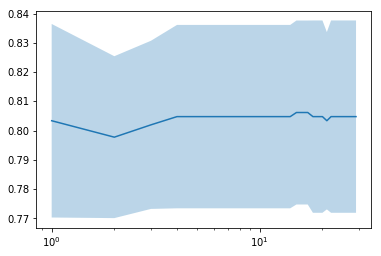

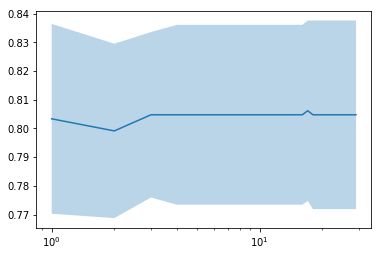

In [355]:
def plot_scores(optimizer):
    par_C = [row['C'] for row in optimizer.cv_results_['params']]
    test_score = optimizer.cv_results_['mean_test_score']
    std_test_score = optimizer.cv_results_['std_test_score']
    plt.fill_between(par_C, test_score-std_test_score, 
                     test_score+std_test_score, alpha=0.3)
    plt.semilogx(par_C, test_score)    
    plt.show()
plot_scores(optimizer_l1)
plot_scores(optimizer_l2)

теперь подставим параметры полную обучающую выборку и применим кросс-валидацию. при этом попробуем сбалансировать обучающую выборку

In [360]:
from sklearn.model_selection import cross_val_score
for L in ['l2', 'l1']:
    for MI in [50, 100, 500]:
        for CW in [ None, 'balanced']:
            LR = LogisticRegression(penalty=L, solver='liblinear', max_iter=MI, class_weight=CW) 
            scores = cross_val_score(LR, X_full_train, y_full_train, cv=5)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.02)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.80 (+/- 0.02)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.80 (+/- 0.02)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.80 (+/- 0.02)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.80 (+/- 0.02)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.80 (+/- 0.02)
Accuracy: 0.77 (+/- 0.01)


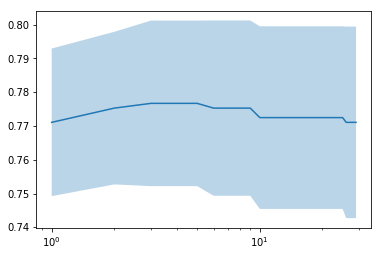

Best parameter for GridSearchCV with balanced weights {'C': 3}
roc_auc_score 0.8521739130434783
0.776685393258427


In [343]:
param_grid = {'C': xx}
cv = 3
estimator = LogisticRegression(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train, y_train)
# Убедитесь в том, что нашли оптимум accuracy по гиперпараметрам.
# Оцените качество классификатора метрике AUC ROC на тестовой выборке.
plot_scores(optimizer)
print 'Best parameter for GridSearchCV with balanced weights', optimizer.best_params_
roc_auc_score_strat = roc_auc_score(y_val, optimizer.best_estimator_.predict_proba(X_val)[:, 1])
print 'roc_auc_score', roc_auc_score_strat
print optimizer.best_score_ 

In [347]:
param_grid = {'C': [9]}
cv = 5
estimator = LogisticRegression(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train, y_train)
logreg_pred_test = optimizer.predict(X_val)
logreg_test_accuracy = accuracy_score(y_val, logreg_pred_test)
display(logreg_test_accuracy)

0.770949720670391

#### Решающие деревья
Решающие деревья воспроизводят логические схемы, позволяющие получить окончательное решение о классификации объекта спомощью ответов на иерархически организованную систему вопросов.Причём вопрос, задаваемый на последующем иерархическом уровне,зависит от ответа, полученного на предыдущем уровне. 

In [175]:
from sklearn.tree import DecisionTreeClassifier

для начала используем параметры по умолчанию без применения кросс-валидации

In [176]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
pred = clf_tree.predict(X_val)
display(accuracy_score(y_val, pred))

0.7821229050279329

теперь с приенением кросс-валидации

In [361]:
from sklearn.model_selection import cross_val_score
clf_tree_CV = DecisionTreeClassifier()
scores = cross_val_score(clf_tree_CV, X_full_train, y_full_train, cv=5)
display(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([0.74860335, 0.74301676, 0.80898876, 0.74719101, 0.79661017])

Accuracy: 0.77 (+/- 0.06)


видим, что на самом деле показатель ниже

#### Случайный лес
Случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.
Бэггинг - это технология классификации, использующая композиции алгоритмов, каждый из  которых обучается независимо. Результат классификации определяется путем голосования. 
Бэггинг позволяет снизить процент ошибки классификации в случае, когда высока дисперсия 
ошибки базового метода.  

In [178]:
from sklearn.ensemble import RandomForestClassifier

In [179]:
rnd_frst = RandomForestClassifier()
rnd_frst.fit(X_train, y_train)
pred = rnd_frst.predict(X_val)
display(accuracy_score(y_val, pred))

/home/thomas/anaconda2/envs/env_py2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8156424581005587

In [307]:
from sklearn.model_selection import cross_val_score
RFC_l5 = RandomForestClassifier(min_samples_leaf=5)
RFC_l5.fit(X_full_train, y_full_train)
result_RFC_l5 = RFC_l5.predict(X_full_test)
scores = cross_val_score(RFC_l5, X_full_train, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# kaggle 0.76076

Accuracy: 0.82 (+/- 0.03)


отправляем результат на kaggle

In [308]:
submission = pd.DataFrame({'PassengerId':test.PassengerId,'Survived':result_RFC_l5})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic_Predictions_RFC_l5.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic_Predictions_RFC_l5.csv


In [287]:
from sklearn.model_selection import cross_val_score
rnd_frst_castom = RandomForestClassifier(min_samples_leaf=5)
scores = cross_val_score(rnd_frst_castom, X_full_train, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.04)


#### Метод ближайших соседей 
Метод ближайших соседей — простейший метрический классификатор, основанный на оценивании сходства объектов. Классифицируемый объект относится к тому классу, которому принадлежат ближайшие к нему объекты обучающей выборки. 

In [190]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbor = [3,5,7]
for n_neighbors in n_neighbor:
    weight = ['uniform', 'distance']
    for weights in weight: 
        ps = [1, 2]
        for p in ps:
            neigh = KNeighborsClassifier(n_neighbors, weights, p=p)
            neigh.fit(X_train, y_train) 
            predict = neigh.predict(X_val)
            print accuracy_score(y_val, predict), n_neighbors, weights, p

0.7821229050279329 3 uniform 1
0.7318435754189944 3 uniform 2
0.770949720670391 3 distance 1
0.7206703910614525 3 distance 2
0.7541899441340782 5 uniform 1
0.770949720670391 5 uniform 2
0.7597765363128491 5 distance 1
0.7486033519553073 5 distance 2
0.8044692737430168 7 uniform 1
0.7541899441340782 7 uniform 2
0.8100558659217877 7 distance 1
0.7430167597765364 7 distance 2


In [239]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbor = [3,5,7]
for n_neighbors in n_neighbor:
    weight = ['uniform', 'distance']
    for weights in weight: 
        ps = [1, 2]
        for p in ps:
            neigh = KNeighborsClassifier(n_neighbors, weights, p=p)
            scores = cross_val_score(neigh, X_full_train, y_full_train, cv=5)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.04)
Accuracy: 0.72 (+/- 0.03)
Accuracy: 0.75 (+/- 0.06)
Accuracy: 0.71 (+/- 0.05)
Accuracy: 0.74 (+/- 0.04)
Accuracy: 0.70 (+/- 0.06)
Accuracy: 0.74 (+/- 0.05)
Accuracy: 0.71 (+/- 0.05)
Accuracy: 0.73 (+/- 0.07)
Accuracy: 0.71 (+/- 0.09)
Accuracy: 0.75 (+/- 0.09)
Accuracy: 0.72 (+/- 0.07)


#### Бэггинг 
Бэггинг - это технология классификации, использующая композиции алгоритмов, каждый из  которых обучается независимо. Результат классификации определяется путем голосования. 
Бэггинг позволяет снизить процент ошибки классификации в случае, когда высока дисперсия 
ошибки базового метода.  

In [269]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
for BE in [None, neigh, rnd_frst]:
    for NE in [10, 100]:
        for MF in [1, 5]:
            # создаем объект класса BaggingClassifier. отдельно указываем количество деревьев == 100
            bagging_classifier = BaggingClassifier(base_estimator=BE, n_estimators = NE,
                                                  max_features=MF )
            # усредняем оценку качества перекрестной проверки на 5 фолдах
            scores = cross_val_score(bagging_classifier, X_full_train, y_full_train, cv=5)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)), BE, NE, MF

Accuracy: 0.75 (+/- 0.08) None 10 1
Accuracy: 0.83 (+/- 0.02) None 10 5
Accuracy: 0.78 (+/- 0.06) None 100 1
Accuracy: 0.83 (+/- 0.03) None 100 5
Accuracy: 0.75 (+/- 0.06) KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance') 10 1
Accuracy: 0.81 (+/- 0.06) KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance') 10 5
Accuracy: 0.75 (+/- 0.07) KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance') 100 1
Accuracy: 0.81 (+/- 0.07) KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance') 100 5
Accuracy: 0.74 (+/- 0.13) RandomForestClassifier(bootstr

In [272]:
bagging_classifier = BaggingClassifier(base_estimator=rnd_frst, n_estimators = 100,
                                                  max_features=5 )
            # усредняем оценку качества перекрестной проверки на 5 фолдах
scores = cross_val_score(bagging_classifier, X_full_train, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# kaggle - 0.76076

Accuracy: 0.83 (+/- 0.06)


In [305]:
DT = DecisionTreeClassifier(splitter='random')
bagging_classifier = BaggingClassifier(base_estimator=DT, n_estimators = 10,
                                                  max_features=5 )
bagging_classifier.fit(X_full_train, y_full_train)
result_b_DT = bagging_classifier.predict(X_full_test)
            # усредняем оценку качества перекрестной проверки на 5 фолдах
scores_b_RFC = cross_val_score(bagging_classifier, X_full_train, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.05)


### Лучший результат получен при помощи бэггинга с базовым алгоритмом в виде дерева решений, ансамблем из 10 алгоритмов и количестве признаков, которые следует учитывать для дальнейшего разделения равным 5.

In [294]:
bagging_classifier = BaggingClassifier(base_estimator= None, n_estimators = 10,
                                                  max_features=5 )
bagging_classifier.fit(X_full_train, y_full_train)
result_b_RF = bagging_classifier.predict(X_full_test)
scores = cross_val_score(bagging_classifier, X_full_train, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# kaggle - 0.76555 - the best result

Accuracy: 0.82 (+/- 0.05)


In [276]:
bagging_classifier = BaggingClassifier(base_estimator=rnd_frst, n_estimators = 100,
                                                  max_features=5 )
bagging_classifier.fit(X_full_train, y_full_train)
result = bagging_classifier.predict(X_full_test)

In [313]:
submission = pd.DataFrame({'PassengerId':test.PassengerId,'Survived':result_b_RF})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic_Predictions_b_RF.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic_Predictions_b_RF.csv


In [192]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_val, y_val) 

0.7877094972067039

In [193]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_full_train, y_full_train, cv=5)
display(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([0.80446927, 0.80446927, 0.78651685, 0.75280899, 0.78531073])

Accuracy: 0.79 (+/- 0.04)


далее несколько экспериентов над данными без признака "Тип билета"

In [310]:
X_full_train_short = X_full_train
X_full_test_short = X_full_test
for dataset in [X_full_train_short, X_full_test_short]:
    dataset.drop(columns=['Ticket_level'], inplace=True)
X_full_train_short.head(3)

,Sex,Embarked,title,Fare,Age,Pclass,Alone
0,1,0.1,1,7.2500,22.0,3.0,0
1,2,0.2,3,71.2833,38.0,1.0,0
2,2,0.1,2,7.9250,26.0,3.0,1


In [312]:
bagging_classifier_short = BaggingClassifier(base_estimator= None, n_estimators = 10,
                                                  max_features=5 )
bagging_classifier_short.fit(X_full_train_short, y_full_train)
result_b_RF_s = bagging_classifier_short.predict(X_full_test_short)
scores = cross_val_score(bagging_classifier, X_full_train_short, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# kaggle 

Accuracy: 0.82 (+/- 0.05)


In [316]:
RFC_full = RandomForestClassifier(criterion='entropy', n_estimators=700, min_samples_split=10, 
                             min_samples_leaf=1, max_features='auto', 
                             oob_score=True, random_state=1, n_jobs=-1)
scores = cross_val_score(RFC_full, X_full_train_short, y_full_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# kaggle - 0.76555

Accuracy: 0.83 (+/- 0.05)


In [318]:
RFC_full.fit(X_full_train_short, y_full_train)
result_RFC_full = RFC_full.predict(X_full_test_short)
submission = pd.DataFrame({'PassengerId':test.PassengerId,'Survived':result_RFC_full})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic_Predictions_RFC_full.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic_Predictions_RFC_full.csv


In [327]:
X_full_train_S = pd.merge(X_full_train, train['Survived'], left_index=True, right_index=True ) 


In [328]:
X_full_train_S.head(3)

,Sex,Embarked,title,Fare,Age,Pclass,Alone,Survived
0,1,0.1,1,7.2500,22.0,3.0,0,0
1,2,0.2,3,71.2833,38.0,1.0,0,1
2,2,0.1,2,7.9250,26.0,3.0,1,1


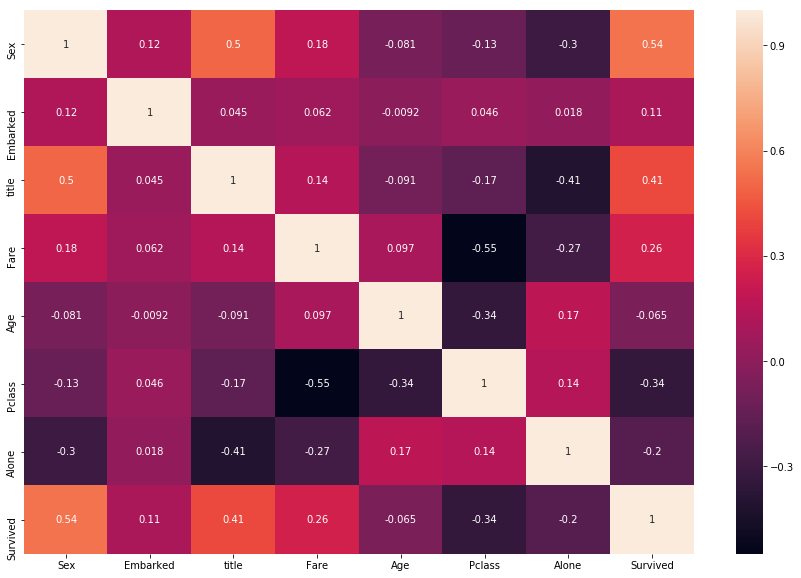

In [329]:
plt.figure(figsize=(15,10))
sns.heatmap(X_full_train_S.corr(), annot=True)
plt.show()

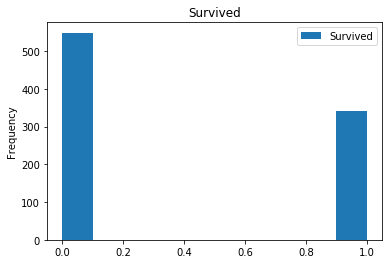

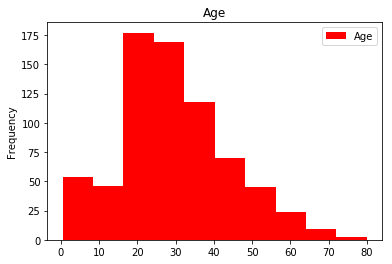

In [84]:
train.plot(y='Survived', kind='hist',  title='Survived')
train.plot(y='Age', kind='hist', 
           color='red',  title='Age')

In [372]:
from math import sqrt
# создаем объект класса DecisionTreeClassifier. отдельно указываем количество признаков - features_sqrt 
features_sqrt = int(sqrt(X_full_train.shape[1]))
F = [1, 2, features_sqrt]
for MF in F: 
    DTC_sqrt = DecisionTreeClassifier(max_features = MF)
    # передаем объект в качестве аргумента в бэггинг классификатор
    bagging_classifier_by_DTC_sqrt = BaggingClassifier(DTC_sqrt, n_estimators = 100)
    # измеряем качество. усредняем оценку качества перекрестной проверки на 10 фолдах
    CVS_for_DT_by_features_sqrt = cross_val_score(bagging_classifier_by_DTC_sqrt, X_full_train, y_full_train, cv=10)
    # Если выбирать случайные признаки в каждой вершине, отличия между деревьями становятся 
    # еще более существенными, что хорошо сказывается на качестве работы композиции. 
    # Именно так и устроен случайный лес.
    display(CVS_for_DT_by_features_sqrt)
    print("Accuracy: %0.2f (+/- %0.2f)" % (CVS_for_DT_by_features_sqrt.mean(), CVS_for_DT_by_features_sqrt.std() * 2))

array([0.74444444, 0.88888889, 0.76404494, 0.84269663, 0.85393258,
       0.85393258, 0.80898876, 0.75280899, 0.79775281, 0.84090909])

Accuracy: 0.81 (+/- 0.09)


array([0.74444444, 0.87777778, 0.75280899, 0.82022472, 0.84269663,
       0.84269663, 0.83146067, 0.76404494, 0.80898876, 0.82954545])

Accuracy: 0.81 (+/- 0.08)


array([0.76666667, 0.88888889, 0.75280899, 0.84269663, 0.86516854,
       0.84269663, 0.82022472, 0.76404494, 0.7752809 , 0.85227273])

Accuracy: 0.82 (+/- 0.09)
